# Scripts for generating plots from the air quality data
The first code cell has to be run before running other cells.

In [ ]:
"""Imports and helper functions required to run other cells
"""


!pip install kaleido
import kaleido
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline
import plotly.express as px
pd.options.plotting.backend = "plotly"
import plotly.io as pio
pio.renderers.default = "browser"
!pip install pyarrow
from collections import defaultdict
import math
import plotly.graph_objects as go
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import itertools as it
import csv
from scipy import stats
from sklearn.model_selection import StratifiedKFold

# remove outliers by replacing values greater than X with the median value
def replace_outliers_median(df, column: str):
    Q = df[column].quantile(0.95)
    historical_max = 352.6 # max historical data from https://powietrze.gios.gov.pl/pjp/archives/downloadFile/423
    median = df[column].quantile(0.50)
    df[column] = np.where(df[column] > historical_max, median, df[column])
    return df

# remove values greater than X
def remove_outliers(df, column: str):
    historical_max = 352.6 # max historical data from https://powietrze.gios.gov.pl/pjp/archives/downloadFile/423
    df = df[df[column] <= historical_max]
    return df

# get dataframe by station id
def get_all_sensor_data(dir_path, id: str):
    sensor_dfs = []
    for file_name in os.listdir(dir_path):
        if file_name.startswith(id):
            sensor_df = pd.read_feather(os.path.join(dir_path, file_name))
            # print(f"max before: {sensor_df['PM2.5[calibrated]'].max()}")
            sensor_df = remove_outliers(sensor_df, column='PM2.5[calibrated]')
            # print(f"max after: {sensor_df['PM2.5[calibrated]'].max()}")
            sensor_dfs.append(sensor_df)
    return pd.concat(sensor_dfs)


# get data from sensor by station id, year and month
def get_sensor_data(dir_path, id: str, year = "2020", month = "05"):
    for file_name in os.listdir(dir_path):
        if file_name.startswith(id):
            file_year = file_name[file_name.find('_') + 1: file_name.rfind('_')]
            file_month = file_name[file_name.rfind('_') + 1: file_name.rfind('.')]
            if file_year == year and file_month == month:
                sensor_df = pd.read_feather(os.path.join(dir_path, file_name))
                sensor_df.drop(sensor_df[sensor_df['timestamp'].dt.month != int(month)].index, inplace=True)  # drop rows with incorrect month
                sensor_df = remove_outliers(sensor_df, column='PM2.5[calibrated]')
                sensor_df['timestamp'] = pd.to_datetime(sensor_df['timestamp'])
                sensor_df.set_index('timestamp', inplace=True)
                return sensor_df


def get_polish_aqi(x):
    if x <= 13:
        return "Very good"
    elif x <= 35:
        return "Good"
    elif x <= 55:
        return "Moderate"
    elif x <= 75:
        return "Satisfactory"
    elif x <= 110:
        return "Bad"
    elif x > 110:
        return "Hazardous"
    else:
        return np.NaN


def get_polish_aqi_num(x):
    if x <= 13:
        return 1
    elif x <= 35:
        return 2
    elif x <= 55:
        return 3
    elif x <= 75:
        return 4
    elif x <= 110:
        return 5
    elif x > 110:
        return 6
    else:
        return np.NaN


def get_eu_aqi(x):
    if x <= 10:
        return "Good [1]"
    elif x <= 20:
        return "Fair [2]"
    elif x <= 25:
        return "Moderate [3]"
    elif x <= 50:
        return "Poor [4]"
    elif x <= 75:
        return "Very poor [5]"
    elif x > 75:
        return "Extremely poor [6]"
    else:
        return np.NaN


def get_eu_aqi_num(x):
    if x <= 10:
        return 1
    elif x <= 20:
        return 2
    elif x <= 25:
        return 3
    elif x <= 50:
        return 4
    elif x <= 75:
        return 5
    elif x > 75:
        return 6
    else:
        return np.NaN


def dict_to_plotly(dictionary):
    return {'z': [v for v in dictionary.values()],
            'x': [t[0] for t in dictionary.keys()],
            'y': [t[1] for t in dictionary.keys()]}

# add column with AQI transition
def add_aqi_columns(df, polish_aqi=True):
    for column in df.columns:
        if column.endswith('PM2.5[calibrated]'):
            aqi_transitions_list = []
            aqi_lvl_difference_list = []
            for i in range(len(df)):
                row_t = df.iloc[i]
                if i < len(df) - 1:
                    row_t1 = df.iloc[i + 1]
                else:
                    row_t1 = df.iloc[i]

                if polish_aqi:
                    row_t_aqi_num = get_polish_aqi_num(row_t[column])
                    row_t1_aqi_num = get_polish_aqi_num(row_t1[column])
                else:
                    row_t_aqi_num = get_eu_aqi_num(row_t[column])
                    row_t1_aqi_num = get_eu_aqi_num(row_t1[column])

                # aqi_transitions_list.append((row_t_aqi, row_t1_aqi))
                aqi_transitions_list.append((row_t_aqi_num, row_t1_aqi_num))
                aqi_lvl_difference_list.append(abs(row_t1_aqi_num - row_t_aqi_num))

            df[f'AQI_change'] = aqi_transitions_list
            df[f'AQI_difference'] = aqi_lvl_difference_list

In [31]:
"""Average pm25 heatmaps: each month of year, multiple sensors, at given timewindow

The function takes in the following arguments:
1. input_dir - path to the input directory with .feather files containing readings from the sensor nodes from different months and years
2. output_dir - path to the output directory which will contain output plot files
3. sensor_ids - list of sensor node IDs in form of strings, e.g. ["1001", "1002", "1003"]
4. year - the year for which the plot should be generated, e.g. "2019"
5. window - a time window the data will be averaged with, e.g. '15min'. Other possible windows: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
6. title - the title shown in the upper part of the plot
"""

def show_year_months_heatmap(input_dir, output_dir, sensor_ids, year ="2021", window="15min", title="default title"):
    pio.renderers.default = "browser"
    months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
    dfs = []
    for sensor_id in sensor_ids:
        month_dfs = []
        for month in months:
            df = get_sensor_data(input_dir, sensor_id, year, month)
            if df is not None:
                df = df['PM2.5[calibrated]']
                month_dfs.append(df)

        if len(month_dfs):
            all_months_df = pd.concat(month_dfs)
            all_months_df = all_months_df.resample(window).mean()
            dfs.append(pd.DataFrame(all_months_df))


    all_days_df = pd.concat(dfs, axis=1)
    all_days_df = all_days_df.mean(axis=1)
    months_grouped_df = all_days_df.groupby(all_days_df.index.month).apply(list)


    matrix = []

    for month_number, day_data in months_grouped_df.iteritems():
        day_data = [round(x, 0) for x in day_data]
        matrix.append(day_data)

    max_len = max([len(i) for i in matrix])
    matrix = [row + [np.NaN] * (max_len - len(row)) for row in matrix]

    fig = px.imshow(np.array(matrix), title=f"{title} average PM<sub>2.5</sub> [µg/m<sup>3</sup>], year {year}", text_auto=True, labels=dict(x=f"Day", y="Month", color="PM_2.5"), color_continuous_scale='rdylgn_r', template='plotly')
    fig.update_layout(xaxis = dict(
        tickmode = 'array',
        tickvals = [x for x in range(31)],
        ticktext = [x+1 for x in range(32)]
    ),
    yaxis = dict(
        tickmode = 'array',
        tickvals = [x for x in range(12)],
        ticktext = [str(x+1).zfill(2) for x in range(13)]
    )
    )

    if not os.path.exists(output_dir):
      os.makedirs(output_dir)

    output_file = os.path.join(output_dir, f"{output_dir}_{year}_{window}.html")
    fig.write_html(output_file, include_plotlyjs='cdn')
    # fig.write_image(f"{title}_{year}_{window}.png", width=1000, height=500, scale=3)
    # fig.show()

sensor_ids_main = ['1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009'] # main campus
sensor_ids_wittiga = ['1010'] # T-19 Wittiga
sensor_ids_gdanska = ['1012'] # F-3 Gdanska
sensor_ids_geo = ['1013'] # L-1 Na Grobli
sensor_ids_dluga = ['1014'] # M-2 Dluga
sensor_ids_prusa = ['1019'] # E-1 Prusa

years = ['2019','2020', '2021', '2022']

for year in years:
    show_year_months_heatmap(
        input_dir='readings',
        output_dir='main',
        sensor_ids=sensor_ids_main,
        year = year,
        window = '1D',
        title='Main campus')

    show_year_months_heatmap(
        input_dir='readings',
        output_dir='wittiga',
        sensor_ids=sensor_ids_wittiga,
        year = year,
        window = '1D',
        title='Wittiga St.')

    show_year_months_heatmap(
        input_dir='readings',
        output_dir='bujwida',
        sensor_ids=sensor_ids_gdanska,
        year = year,
        window = '1D',
        title='Bujwida St.')

    show_year_months_heatmap(
        input_dir='readings',
        output_dir='nagrobli',
        sensor_ids=sensor_ids_geo,
        year = year,
        window = '1D',
        title='Na Grobli St.')

    show_year_months_heatmap(
        input_dir='readings',
        output_dir='dluga',
        sensor_ids=sensor_ids_dluga,
        year = year,
        window = '1D',
        title='Dluga St.')

    show_year_months_heatmap(
        input_dir='readings',
        output_dir='prusa',
        sensor_ids=sensor_ids_prusa,
        year = year,
        window = '1D',
        title='Prusa St.')


C:\Users\jpawl\AppData\Local\Temp\ipykernel_11504\334467422.py:30: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\jpawl\AppData\Local\Temp\ipykernel_11504\334467422.py:30: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\jpawl\AppData\Local\Temp\ipykernel_11504\334467422.py:30: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\jpawl\AppData\Local\Temp\ipykernel_11504\334467422.py:30: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\jpawl\AppData\Local\Temp\ipykernel_11504\334467422.py:30: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\jpawl\AppData\Local\Temp\ipykernel_11504\334467422.py:30: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .it

In [3]:
"""PM2.5 changes heatmap for group of sensors

The function takes in the following arguments:
1. input_dir - path to the input directory with .feather files containing readings from the sensor nodes from different months and years
2. output_dir - path to the output directory which will contain output plot files
3. sensor_ids - list of sensor node IDs in form of strings, e.g. ["1001", "1002", "1003"]
4. window - a time window the data will be averaged with, e.g. '15min'. Other possible windows: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
5. min_pm25 - the lower limit of PM2.5 concentration shown in the plot's axes
6. divide - integer value by which all data will be divided to make the data points better visible
7. log - boolean value. If True - a log operation will be performed on the z-axis  
8. title - the title shown in the upper part of the plot
"""


def pm25_change_heatmap(input_dir, output_dir, sensor_ids, window="15min", min_pm25=0, divide: int =0, log=False, title='default title'):
    dfs = []
    for sensor_id in sensor_ids:
        sensor_df = get_all_sensor_data(input_dir, sensor_id)
        sensor_df.index = sensor_df['timestamp']
        dfs.append(sensor_df[['PM2.5[calibrated]']])

    sensors_concatenated_df = pd.concat(dfs)
    window_df = sensors_concatenated_df.resample(window).mean()
    window_df = window_df[window_df['PM2.5[calibrated]'] >= min_pm25]
    window_df['PM2.5[calibrated]'] = window_df['PM2.5[calibrated]'].fillna(0).astype('int')

    if divide > 0:
        new_df = pd.DataFrame()
        new_df['PM2.5[calibrated]'] = window_df.groupby(np.arange(len(window_df))//divide).mean()
        new_df['PM2.5[calibrated]'] = new_df['PM2.5[calibrated]'].astype('int')
        window_df = new_df

    d = defaultdict(int)

    for row_current, row_next in zip(window_df.values[:], window_df.values[1:]):
        pm_current = row_current[0]
        pm_next = row_next[0]
        d[pm_current, pm_next] += 1

    if log:
        d = {(k1, k2): math.log(v) for (k1, k2), v in d.items()} # calculate log of dictionary values

    fill_axes(d)

    # to show text labels add: texttemplate="%{text}" as Heatmap argument
    fig = go.Figure(data=go.Heatmap(dict_to_plotly(d), hoverongaps=False, text= [v for v in d.values()], hovertemplate=None))
    fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    title=f"Number of PM<sub>2.5</sub> value transitions, {title}, {window} window average",
    xaxis_title="PM<sub>2.5</sub> (t)",
    yaxis_title="PM<sub>2.5</sub> (t+1)",
    template="plotly")

    # fig.show()

    if not os.path.exists(output_dir):
      os.makedirs(output_dir)

    # fig.write_image(f'{plot_dir}{window}_{title}_min{min_pm25}_no_stratification.png')
    fig.write_html(os.path.join(output_dir, f'{output_dir}_{window}_min{min_pm25}.html'), include_plotlyjs='cdn')


# fills x and y axes with "Nones". Prevents visual glitches
def fill_axes(dictionary):
    x = [t[0] for t in dictionary.keys()]
    for i in range(min(x), max(x)):
        if i not in x:
            dictionary[i, i] = None



sensor_ids_main = ['1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009'] # main campus
sensor_ids_wittiga = ['1010'] # T-19 Wittiga
sensor_ids_gdanska = ['1012'] # F-3 Gdanska
sensor_ids_geo = ['1013'] # L-1 Na Grobli
sensor_ids_dluga = ['1014'] # M-2 Dluga
sensor_ids_prusa = ['1019'] # E-1 Prusa

pm25_change_heatmap(
    input_dir='readings',
    output_dir='main',
    sensor_ids=sensor_ids_main,
    window='15min',
    min_pm25=0,
    divide=0,
    log=True,
    title='Main campus')

pm25_change_heatmap(
    input_dir='readings',
    output_dir='main',
    sensor_ids=sensor_ids_main,
    window='15min',
    min_pm25=50,
    divide=0,
    log=True,
    title='Main campus')

pm25_change_heatmap(
    input_dir='readings',
    output_dir='wittiga',
    sensor_ids=sensor_ids_wittiga,
    window='15min',
    min_pm25=0,
    divide=0,
    log=True,
    title='Wittiga St.')

pm25_change_heatmap(
    input_dir='readings',
    output_dir='wittiga',
    sensor_ids=sensor_ids_wittiga,
    window='15min',
    min_pm25=50,
    divide=0,
    log=True,
    title='Wittiga St.')

pm25_change_heatmap(
    input_dir='readings',
    output_dir='bujwida',
    sensor_ids=sensor_ids_gdanska,
    window='15min',
    min_pm25=0,
    divide=0,
    log=True,
    title='Bujwida St.')

pm25_change_heatmap(
    input_dir='readings',
    output_dir='bujwida',
    sensor_ids=sensor_ids_gdanska,
    window='15min',
    min_pm25=50,
    divide=0,
    log=True,
    title='Bujwida St.')

pm25_change_heatmap(
    input_dir='readings',
    output_dir='nagrobli',
    sensor_ids=sensor_ids_geo,
    window='15min',
    min_pm25=0,
    divide=0,
    log=True,
    title='Na Grobli St.')

pm25_change_heatmap(
    input_dir='readings',
    output_dir='nagrobli',
    sensor_ids=sensor_ids_geo,
    window='15min',
    min_pm25=50,
    divide=0,
    log=True,
    title='Na Grobli St.')

pm25_change_heatmap(
    input_dir='readings',
    output_dir='dluga',
    sensor_ids=sensor_ids_dluga,
    window='15min',
    min_pm25=0,
    divide=0,
    log=True,
    title='Długa St.')

pm25_change_heatmap(
    input_dir='readings',
    output_dir='dluga',
    sensor_ids=sensor_ids_dluga,
    window='15min',
    min_pm25=50,
    divide=0,
    log=True,
    title='Długa St.')

pm25_change_heatmap(
    input_dir='readings',
    output_dir='prusa',
    sensor_ids=sensor_ids_prusa,
    window='15min',
    min_pm25=0,
    divide=0,
    log=True,
    title='Prusa St.')

pm25_change_heatmap(
    input_dir='readings',
    output_dir='prusa',
    sensor_ids=sensor_ids_prusa,
    window='15min',
    min_pm25=50,
    divide=0,
    log=True,
    title='Prusa St.')

In [32]:
"""Average PM25 heatmaps: each day of month, multiple sensors, at given timewindow

The function takes in the following arguments:
1. input_dir - path to the input directory with .feather files containing readings from the sensor nodes from different months and years
2. output_dir - path to the output directory which will contain output plot files
3. sensor_ids - list of sensor node IDs in form of strings, e.g. ["1001", "1002", "1003"]
4. year - the year for which the plot should be generated, e.g. "2019"
5. month - number of the month for which the plot should be generated, e.g. "02"
6. window - a time window the data will be averaged with, e.g. '15min'. Other possible windows: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
7. title - the title shown in the upper part of the plot
"""


def show_month_heatmap(input_dir, output_dir, sensor_ids, year ="2021", month ="02", window="15min", title="default_title"):
    pio.renderers.default = "browser"

    dfs = []
    for sensor_id in sensor_ids:
        df = get_sensor_data(input_dir, sensor_id, year, month)
        if df is None:
            continue
        df = df.resample(window).mean()
        day_numbers = df.index.day.unique().to_list()
        day_numbers.reverse()

        new_df = pd.DataFrame()
        for day in day_numbers:
            day_df = df[df.index.day == day].reset_index()
            new_df[f'{day}.{month}'] = day_df['PM2.5[calibrated]']

        dfs.append(new_df)

    mean_df = pd.concat(dfs)
    mean_df = mean_df.groupby(mean_df.index).mean()
    mean_df.index += 1
    mean_df = mean_df.iloc[:, ::-1]  # reverse column order

    mean_df.to_csv('test.csv', index=True)
    mean_df = mean_df.T

    int_df = mean_df.round(0)

    if not os.path.exists(output_dir):
      os.makedirs(output_dir)

    fig = px.imshow(int_df, title=f"{title} average PM<sub>2.5</sub> [µg/m<sup>3</sup>], {month}-{year}", text_auto=True, labels=dict(x=f"Window ({window})", y="Day of month", color="PM_2.5"), color_continuous_scale='rdylgn_r', template='plotly')
    fig.write_html(os.path.join(output_dir, f"{output_dir}_{year}_{month}.html"), include_plotlyjs='cdn')
    # fig.write_image(f"{title}_{year}_{month}.png", width=1920, height=1080, scale=2)
    # fig.show()

years = ['2019','2020', '2021', '2022']

sensor_ids_main = ['1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009'] # main campus
sensor_ids_wittiga = ['1010'] # T-19 Wittiga
sensor_ids_gdanska = ['1012'] # F-3 Gdanska
sensor_ids_geo = ['1013'] # L-1 Na Grobli
sensor_ids_dluga = ['1014'] # M-2 Dluga
sensor_ids_prusa = ['1019'] # E-1 Prusa

for year in years:
    show_month_heatmap(
        input_dir='readings',
        output_dir='main',
        sensor_ids=sensor_ids_main,
        year = year,
        month = "01",
        window = '15min',
        title='Main campus')

    show_month_heatmap(
        input_dir='readings',
        output_dir='wittiga',
        sensor_ids=sensor_ids_wittiga,
        year = year,
        month = "01",
        window = '15min',
        title='Wittiga St.')

    show_month_heatmap(
        input_dir='readings',
        output_dir='bujwida',
        sensor_ids=sensor_ids_gdanska,
        year = year,
        month = "01",
        window = '15min',
        title='Bujwida St.')

    show_month_heatmap(
        input_dir='readings',
        output_dir='nagrobli',
        sensor_ids=sensor_ids_geo,
        year = year,
        month = "01",
        window = '15min',
        title='Na Grobli St.')

    show_month_heatmap(
        input_dir='readings',
        output_dir='dluga',
        sensor_ids=sensor_ids_dluga,
        year = year,
        month = "01",
        window = '15min',
        title='Dluga St.')

    show_month_heatmap(
        input_dir='readings',
        output_dir='prusa',
        sensor_ids=sensor_ids_prusa,
        year = year,
        month = "01",
        window = '15min',
        title='Prusa St.')


C:\Users\jpawl\AppData\Local\Temp\ipykernel_11504\747943170.py:28: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().



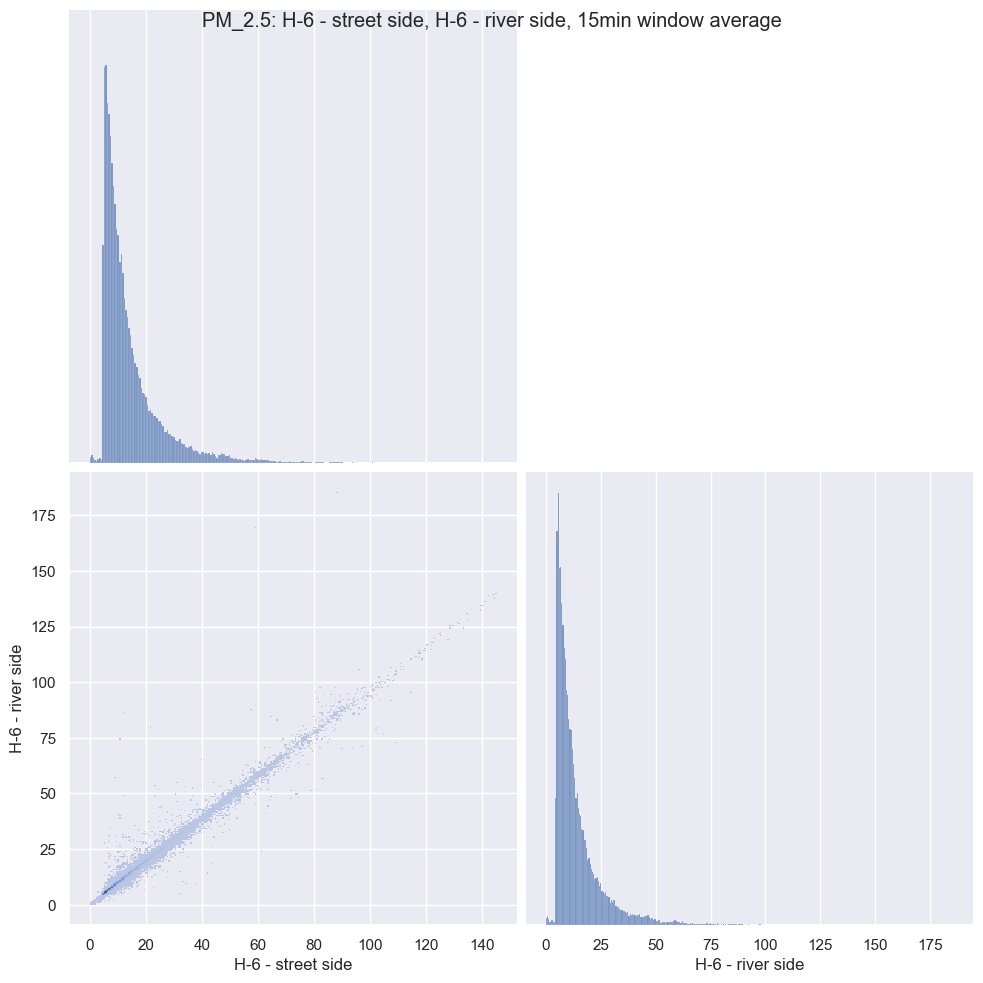

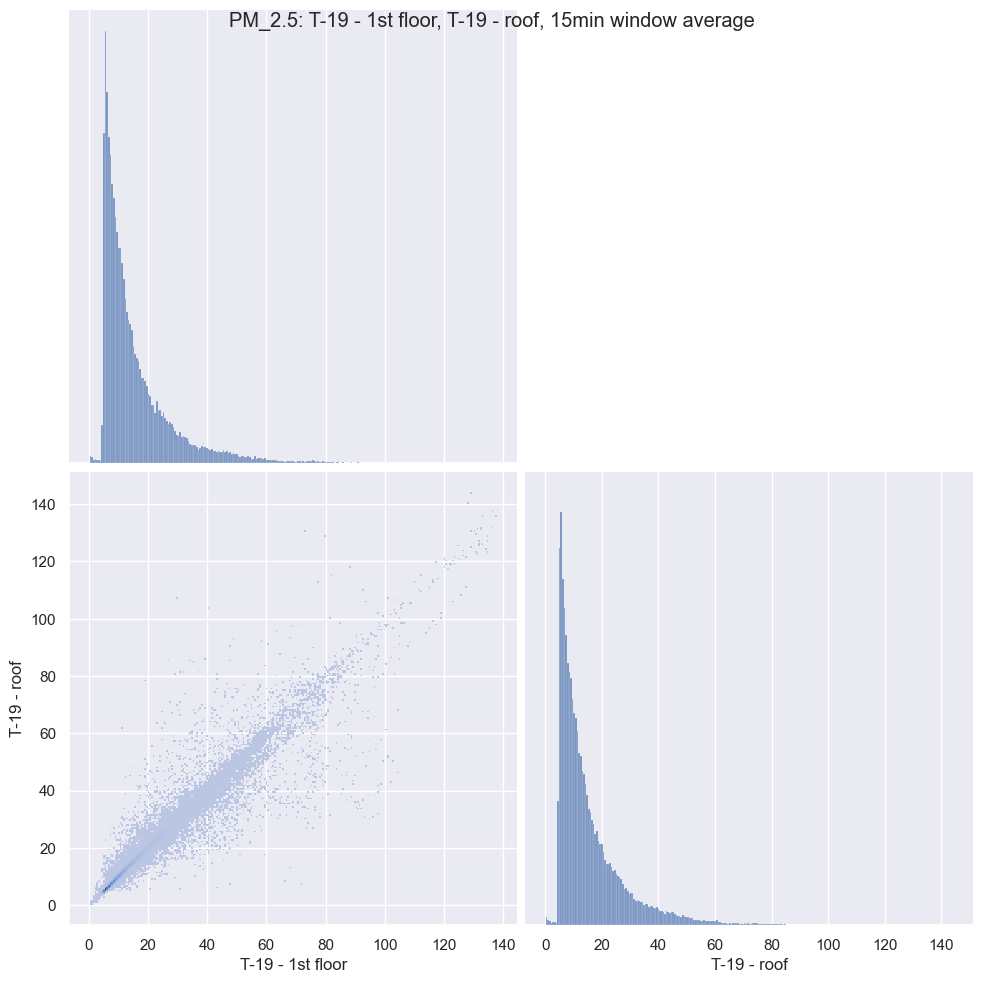

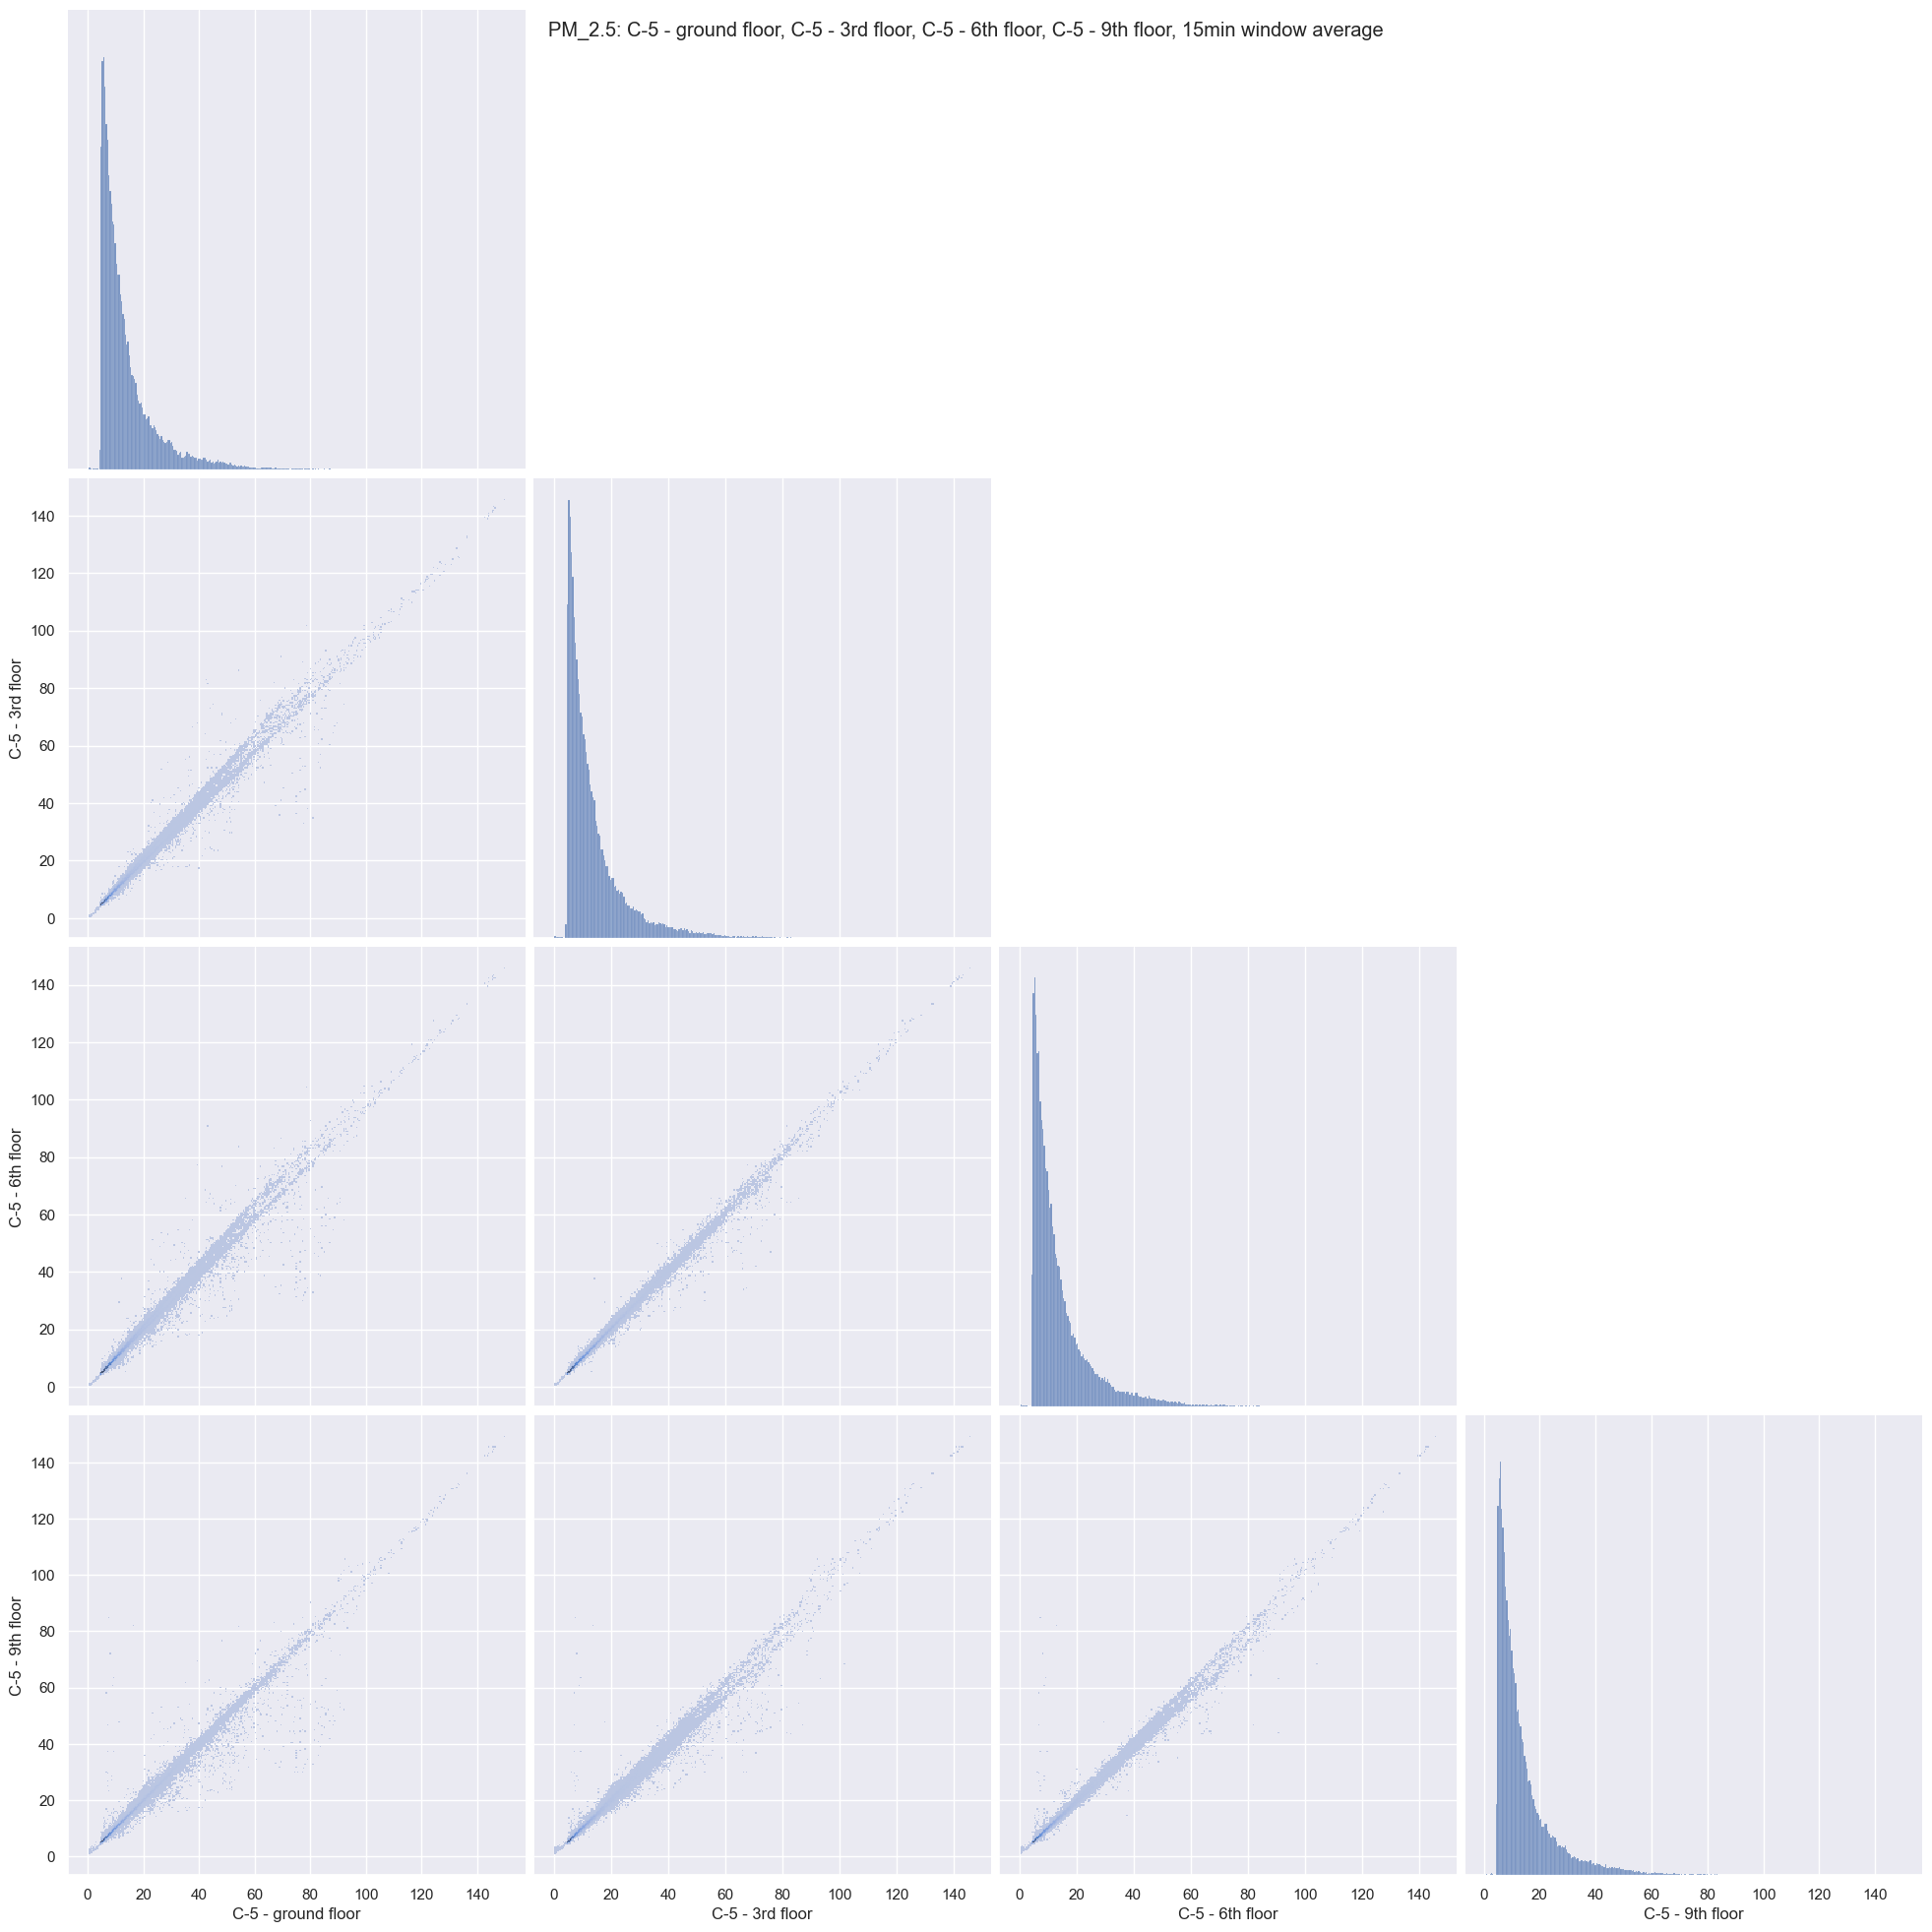

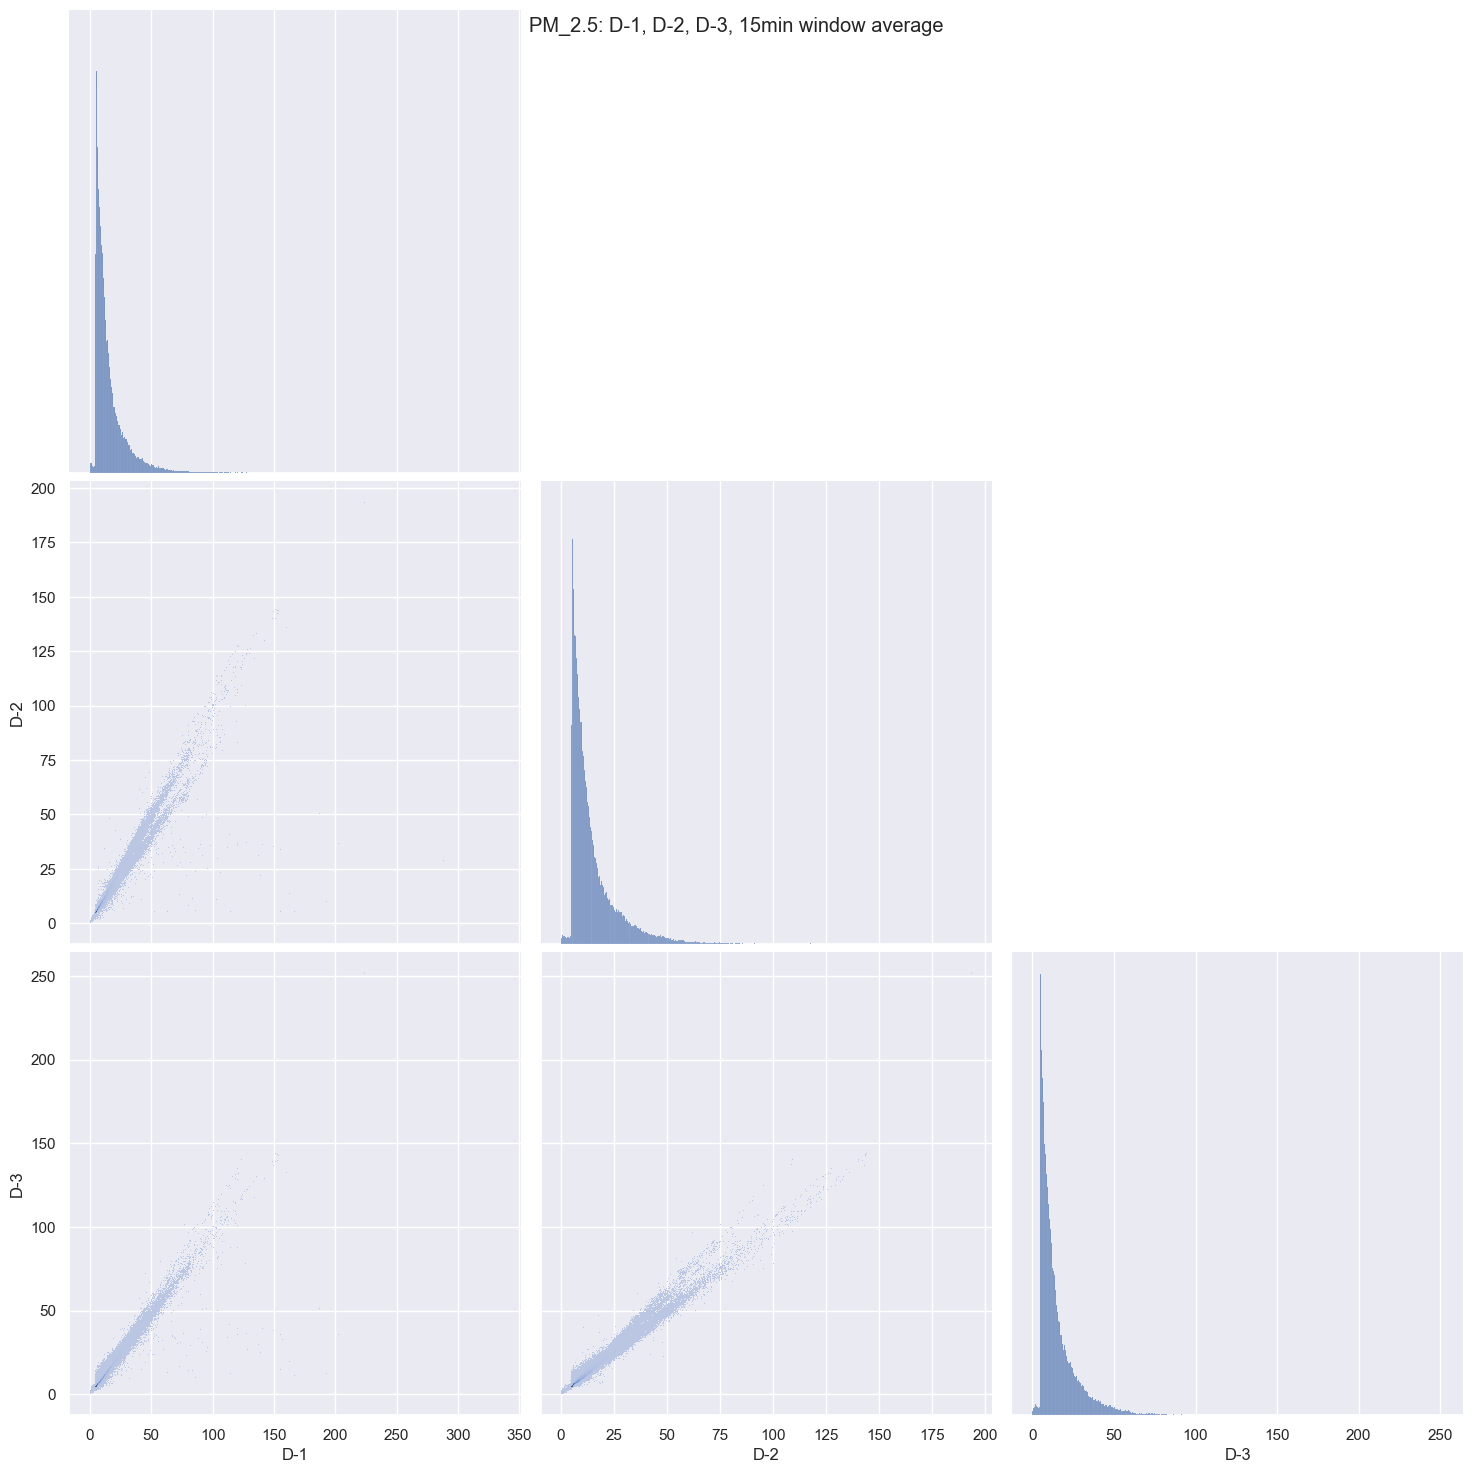

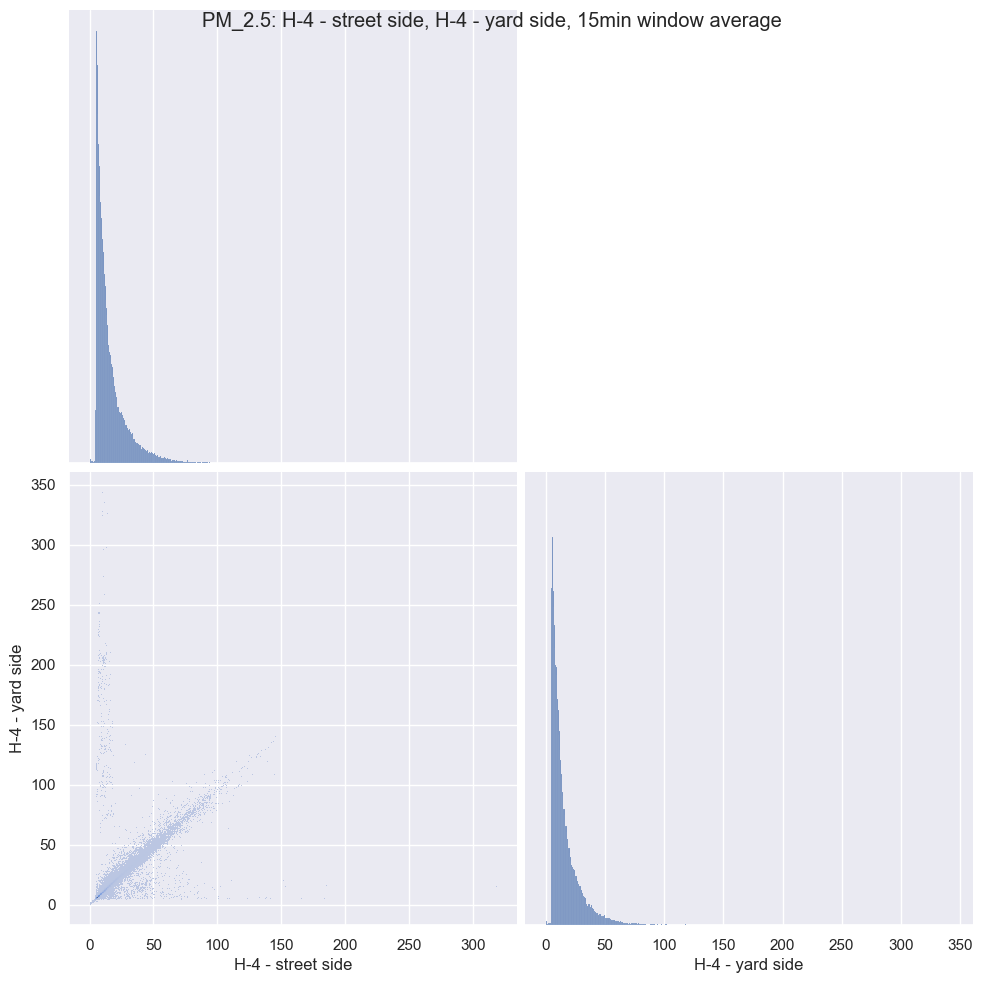

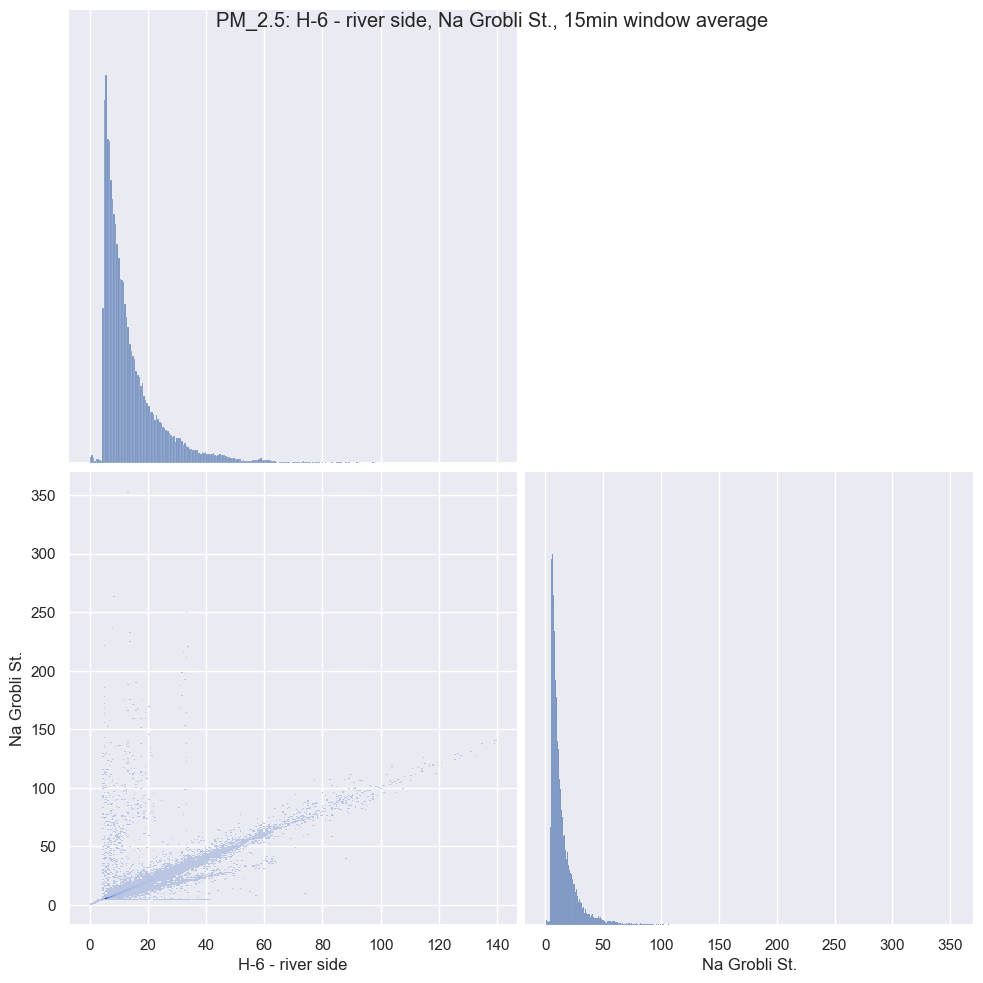

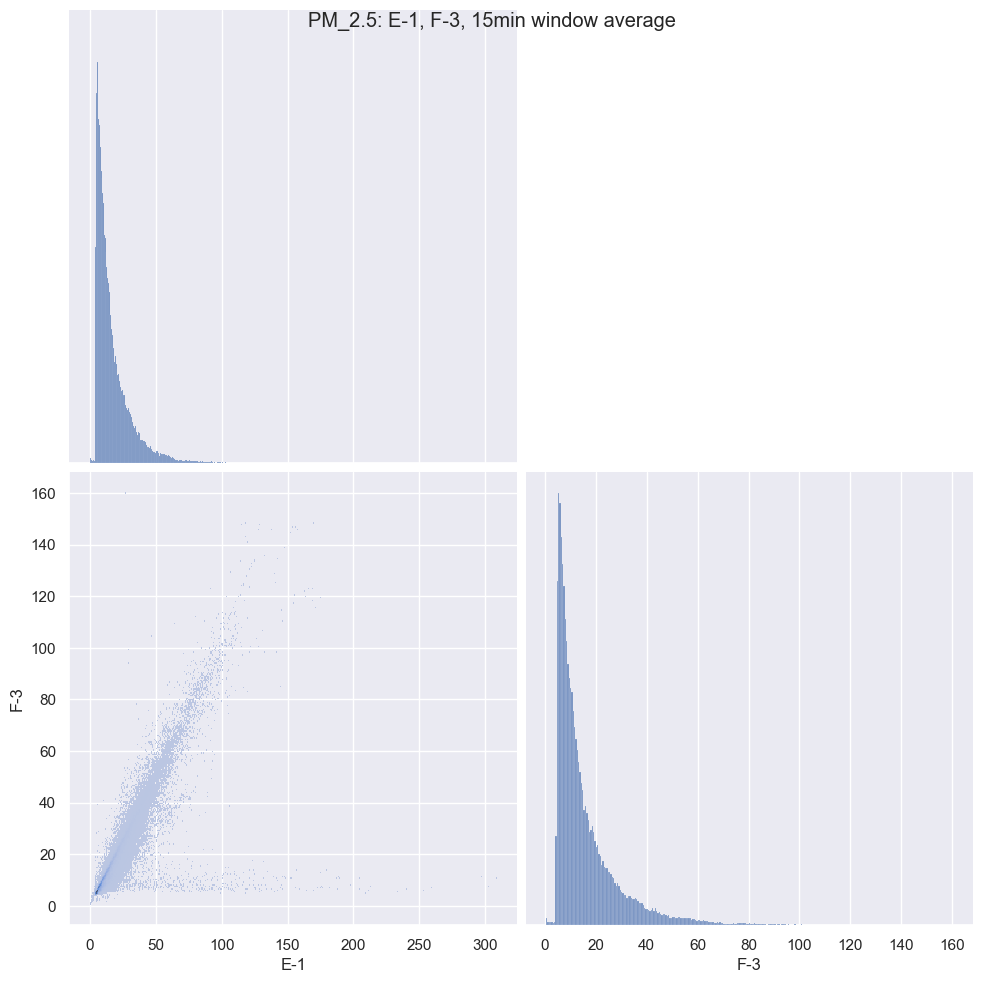

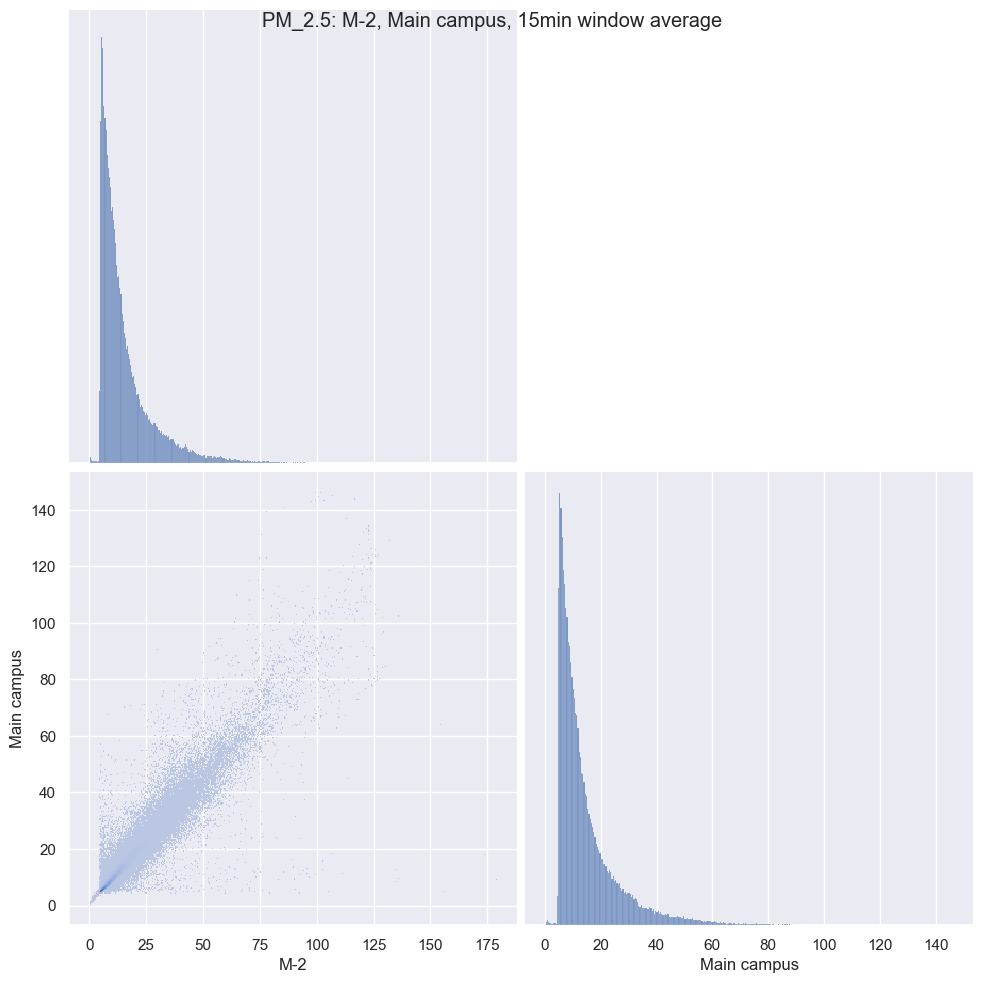

In [28]:
"""PM2.5 pairplots for given station ids

The function takes in the following arguments:
1. input_dir - path to the input directory with .feather files containing readings from the sensor nodes from different months and years
2. output_dir - path to the output directory which will contain output plot files
3. sensor_ids - list of sensor node IDs in form of a dictionary containing IDs of the sensor nodes as the keys and descriptions as the values, e.g. {"1010": "T-19 - 1st floor", "1011": "T-19 - roof"} 
4. window - a time window the data will be averaged with, e.g. '15min'. Other possible windows: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
"""


# helper function
def dict_to_csv(d: dict, filename: str):
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['pair', 'statistic', 'p_value', 'reject_h0'])
        for k, v in d.items():
            a, b = k
            statistic, pvalue = v
            writer.writerow([f'{a}_{b}', statistic, pvalue, pvalue < 0.05])


def group_pairplots(input_dir, output_dir, sensor_ids: dict, window):
    sensor_dfs = []
    for sensor_id, description in sensor_ids.items():
        if sensor_id == 'main':
            main_campus_dfs = []
            sensor_ids_main = ['1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009']
            for i in sensor_ids_main:
                main_campus_df = get_all_sensor_data(input_dir, i)
                main_campus_df.index = main_campus_df['timestamp']
                main_campus_df = main_campus_df[['PM2.5[calibrated]']]
                main_campus_df = main_campus_df.resample(window).mean()
                main_campus_dfs.append(main_campus_df)
            sensor_df = pd.concat(main_campus_dfs, axis=1)
            sensor_df = sensor_df.mean(axis=1, level=0)
        else:
            sensor_df = get_all_sensor_data(input_dir, sensor_id)
            sensor_df.index = sensor_df['timestamp']
        if sensor_df is not None:
            sensor_df = sensor_df[['PM2.5[calibrated]']]
            sensor_df = sensor_df.resample(window).mean()
            sensor_df.rename(columns={'PM2.5[calibrated]': description}, inplace=True)
            sensor_dfs.append(sensor_df[[description]])

    concat_df = pd.concat(sensor_dfs, axis=1)
    concat_df.dropna(inplace=True)

    pl = sns.pairplot(concat_df, kind='hist', height=5, corner=True)
    sns.set(font_scale=1)
    pl.fig.suptitle(f"PM_2.5: {', '.join([d for d in sensor_ids.values()])}, {window} window average")

    if not os.path.exists(output_dir):
      os.makedirs(output_dir)

    plt.savefig(os.path.join(output_dir, f"{output_dir}_{window}.png"), dpi=300)

    combinations = it.combinations(concat_df.columns, 2)
    kstest_dict = dict()
    for (a, b) in combinations:
        statistic, pvalue = stats.kstest(concat_df[a], concat_df[b], alternative='two-sided', mode='auto')
        kstest_dict[a, b] = (statistic, pvalue)
    dict_to_csv(kstest_dict, os.path.join(output_dir, f"{output_dir}_{window}_kstest.csv"))


h6_river_street = {"1007": "H-6 - street side", "1015": "H-6 - river side"} # H-6 river vs street
t19_floors = {"1010": "T-19 - 1st floor", "1011": "T-19 - roof"} # T-19 floors
c5_floors = {"1005": "C-5 - ground floor", "1018": "C-5 - 3rd floor", "1017": "C-5 - 6th floor", "1020": "C-5 - 9th floor"} # C-5 floors
d_buildings = {"1002": "D-1", "1001": "D-2", "1009": "D-3"} # D-1, D-2, D-3 buildings
h4_sides = {"1003": "H-4 - street side", "1016": "H-4 - yard side"} # H-4 yard vs street
river_sides = {"1015": "H-6 - river side", "1013": "Na Grobli St."} # river sides
e1_f3 = {"1019": "E-1", "1012": "F-3"} # E-1, F-3
m2_campus = {"1014": "M-2", "main": "Main campus"} # M-2, main campus


group_pairplots(
    input_dir='readings',
    output_dir='h6',
    sensor_ids=h6_river_street,
    window='15min')

group_pairplots(
    input_dir='readings',
    output_dir='t19',
    sensor_ids=t19_floors,
    window='15min')

group_pairplots(
    input_dir='readings',
    output_dir='c5',
    sensor_ids=c5_floors,
    window='15min')

group_pairplots(
    input_dir='readings',
    output_dir='d',
    sensor_ids=d_buildings,
    window='15min')

group_pairplots(
    input_dir='readings',
    output_dir='h4',
    sensor_ids=h4_sides,
    window='15min')

group_pairplots(
    input_dir='readings',
    output_dir='river_sides',
    sensor_ids=river_sides,
    window='15min')

group_pairplots(
    input_dir='readings',
    output_dir='e1_f3',
    sensor_ids=e1_f3,
    window='15min')

group_pairplots(
    input_dir='readings',
    output_dir='m2_campus',
    sensor_ids=m2_campus,
    window='15min')

In [39]:
"""Calculate MAE for each campus and show as heatmap

The function takes in the following arguments:
1. input_dir - path to the input directory with .feather files containing readings from the sensor nodes from different months and years
2. output_dir - path to the output directory which will contain output plot files
3. window - a time window the data will be averaged with, e.g. '15min'. Other possible windows: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
"""


# helper function
def dict_to_csv(d: dict, filename: str):
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['pair', 'statistic', 'p_value'])
        for k, v in d.items():
            a, b = k
            statistic, pvalue = v
            writer.writerow([f'{a}_{b}', statistic, pvalue])


def campus_MAE_heatmap(input_dir, output_dir, window="15min"):
    campuses_dict = {
        'Main (1001-1009)': ['1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009'],
        'Na Grobli (1013)': ['1013'],
        'Wittiga (1010)': ['1010'],
        'Dluga (1014)': ['1014'],
        'Bujwida (1012)' : ['1012'],
        'Prusa (1019)' : ['1019']}

    campus_dfs = []
    for campus_name, sensor_ids in campuses_dict.items():
        sensor_dfs = []
        for sensor_id in sensor_ids:
            sensor_df = get_all_sensor_data(input_dir, sensor_id)
            sensor_df.index = sensor_df['timestamp']
            sensor_df = sensor_df[['PM2.5[calibrated]']]
            sensor_df = sensor_df.resample(window).mean()
            sensor_dfs.append(sensor_df)
        campus_df = pd.concat(sensor_dfs, axis=1)
        campus_df = campus_df.mean(axis=1, level=0)
        campus_df.rename(columns={'PM2.5[calibrated]': campus_name}, inplace=True)
        campus_dfs.append(campus_df)

    concat_df = pd.concat(campus_dfs, axis=1)

    combinations = [p for p in it.product(campuses_dict.keys(), repeat=2)]
    mae_dict = dict()
    kstest_dict = dict()

    for (a, b) in combinations:
        ab_df = concat_df[[a, b]].copy()
        ab_df.dropna(inplace=True)

        mae_dict[a, b] = mean_absolute_error(ab_df[a], ab_df[b])

        statistic, pvalue = stats.kstest(concat_df[a], concat_df[b], alternative='two-sided', mode='auto')
        kstest_dict[a, b] = (statistic, pvalue)

    fig = go.Figure(data=go.Heatmap(dict_to_plotly(mae_dict), text= [v for v in mae_dict.values()], texttemplate="%{text:.2f}"))
    fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    title=f"PM<sub>2.5</sub> MAE for campuses, {window} window average",
    template="plotly")

    # fig.show()

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    fig.write_html(os.path.join(output_dir, f'{output_dir}_{window}.html'), include_plotlyjs='cdn')
    dict_to_csv(kstest_dict, os.path.join(output_dir, f'{output_dir}_{window}_kstest.csv'))


campus_MAE_heatmap(input_dir='readings', output_dir='campuses_mae', window='15min')

C:\Users\jpawl\AppData\Local\Temp\ipykernel_11504\943414231.py:33: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().

C:\Users\jpawl\AppData\Local\Temp\ipykernel_11504\943414231.py:33: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().

C:\Users\jpawl\AppData\Local\Temp\ipykernel_11504\943414231.py:33: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().

C:\Users\jpawl\AppData\Local\Temp\ipykernel_11504\943414231.py:33: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated

In [6]:
"""Calculate MAE for each station pair and show as heatmap

The function takes in the following arguments:
1. input_dir - path to the input directory with .feather files containing readings from the sensor nodes from different months and years
2. output_dir - path to the output directory which will contain output plot files
3. window - a time window the data will be averaged with, e.g. '15min'. Other possible windows: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
"""


# helper function
def dict_to_csv(d: dict, filename: str):
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['pair', 'statistic', 'p_value'])
        for k, v in d.items():
            a, b = k
            statistic, pvalue = v
            writer.writerow([f'{a}_{b}', statistic, pvalue])


def sensors_MAE_heatmap(input_dir, output_dir, window="15min"):
    sensor_ids = ['1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020']

    sensor_dfs = []
    for sensor_id in sensor_ids:
        print(f'Processing sensor {sensor_id}')
        sensor_df = get_all_sensor_data(input_dir, sensor_id)
        sensor_df.index = sensor_df['timestamp']
        sensor_df = sensor_df[['PM2.5[calibrated]']]
        sensor_df.rename(columns={'PM2.5[calibrated]': sensor_id}, inplace=True)
        sensor_df = sensor_df.resample(window).mean()
        sensor_dfs.append(sensor_df[[sensor_id]])

    concat_df = pd.concat(sensor_dfs, axis=1)

    combinations = [p for p in it.product(sensor_ids, repeat=2)]
    mae_dict = dict()
    kstest_dict = dict()

    for (a, b) in combinations:
        ab_df = concat_df[[a, b]].copy()
        ab_df.dropna(inplace=True)

        mae_dict[a, b] = mean_absolute_error(ab_df.iloc[:, 0], ab_df.iloc[:, 1])

        statistic, pvalue = stats.kstest(ab_df.iloc[:, 0], ab_df.iloc[:, 1], alternative='two-sided', mode='auto')
        kstest_dict[a, b] = (statistic, pvalue)

    fig = go.Figure(data=go.Heatmap(dict_to_plotly(mae_dict), text= [v for v in mae_dict.values()], texttemplate="%{text:.2f}"))
    fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    title=f"PM<sub>2.5</sub> MAE for pairs of sensor nodes, {window} window average",
    template="plotly")

    # fig.show()

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    fig.write_html(os.path.join(output_dir, f'{output_dir}_{window}_no_stratification.html'), include_plotlyjs='cdn')
    dict_to_csv(kstest_dict, os.path.join(output_dir,f'{output_dir}_{window}_kstest_no_stratification.csv' ))


sensors_MAE_heatmap(input_dir='readings', output_dir='sensors_mae', window='15min')

Processing sensor 1001
Processing sensor 1002
Processing sensor 1003
Processing sensor 1004
Processing sensor 1005
Processing sensor 1006
Processing sensor 1007
Processing sensor 1008
Processing sensor 1009
Processing sensor 1010
Processing sensor 1011
Processing sensor 1012
Processing sensor 1013
Processing sensor 1014
Processing sensor 1015
Processing sensor 1016
Processing sensor 1017
Processing sensor 1018
Processing sensor 1019
Processing sensor 1020


In [11]:
"""Calculate MAE for each station pair and show as heatmap, with stratification according to Polish AQI

The function takes in the following arguments:
1. input_dir - path to the input directory with .feather files containing readings from the sensor nodes from different months and years
2. output_dir - path to the output directory which will contain output plot files
3. window - a time window the data will be averaged with, e.g. '15min'. Other possible windows: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
"""


# helper function
def dict_to_csv_stratification(d: dict, filename: str):
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['pair', 'split_number', 'statistic', 'p_value'])
        for k, v in d.items():
            a, b, split_num = k
            statistic, pvalue = v
            writer.writerow([f'{a}_{b}', split_num, statistic, pvalue])


def sensors_mae_heatmap_stratified(input_dir, output_dir, window="15min"):
    sensor_ids = ['1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020']

    sensor_dfs = []
    for sensor_id in sensor_ids:
        print(f'Processing sensor {sensor_id}')
        sensor_df = get_all_sensor_data(input_dir, sensor_id)
        sensor_df.index = sensor_df['timestamp']
        sensor_df = sensor_df[['PM2.5[calibrated]']]
        sensor_df = sensor_df.resample(window).mean()
        sensor_df[f'{sensor_id}_AQI'] = sensor_df['PM2.5[calibrated]'].apply(get_polish_aqi)
        sensor_df.rename(columns={'PM2.5[calibrated]': sensor_id}, inplace=True)
        sensor_dfs.append(sensor_df[[sensor_id, f'{sensor_id}_AQI']])

    concat_df = pd.concat(sensor_dfs, axis=1)

    skf = StratifiedKFold(n_splits=10)

    combinations = [p for p in it.product(sensor_ids, repeat=2)]
    mae_dict = dict()
    kstest_dict = dict()

    for (a, b) in combinations:
        ab_df = concat_df[[a, f'{a}_AQI', b, f'{b}_AQI']].copy()
        ab_df.dropna(inplace=True)

        a_x = ab_df.iloc[:, 0].values # first element of pair - pm2.5
        a_y = ab_df.iloc[:, 1].values # first element of pair - aqi

        b_x = ab_df.iloc[:, 2].values # second element of pair - pm2.5
        b_y = ab_df.iloc[:, 3].values # second element of pair - aqi

        sum_mae = 0
        split_num = 0
        for (a_train_index, a_test_index), (b_train_index, b_test_index) in zip(skf.split(a_x, a_y), skf.split(b_x, b_y)):
            split_num += 1
            split_mae = mean_absolute_error(ab_df.iloc[:, 0][a_test_index], ab_df.iloc[:, 2][b_test_index])
            sum_mae += split_mae

            statistic, pvalue = stats.kstest(ab_df.iloc[:, 0][a_test_index], ab_df.iloc[:, 2][b_test_index], alternative='two-sided', mode='auto')
            kstest_dict[a, b, split_num] = (statistic, pvalue)
        avg_mae = sum_mae/10
        mae_dict[a, b] = avg_mae


    fig = go.Figure(data=go.Heatmap(dict_to_plotly(mae_dict), text= [v for v in mae_dict.values()], texttemplate="%{text:.2f}"))
    fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    title=f"PM<sub>2.5</sub> MAE for pairs of sensor nodes, {window} window average. Stratified data.",
    template='plotly')

    # fig.show()

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    fig.write_html(os.path.join(output_dir, f'{output_dir}_{window}_stratification.html'), include_plotlyjs='cdn')
    dict_to_csv_stratification(kstest_dict, os.path.join(output_dir,f'{output_dir}_{window}_kstest_stratification.csv' ))


sensors_mae_heatmap_stratified(input_dir='readings', output_dir='sensors_mae', window='15min')

Processing sensor 1001
Processing sensor 1002
Processing sensor 1003
Processing sensor 1004
Processing sensor 1005
Processing sensor 1006
Processing sensor 1007
Processing sensor 1008
Processing sensor 1009
Processing sensor 1010
Processing sensor 1011
Processing sensor 1012
Processing sensor 1013
Processing sensor 1014
Processing sensor 1015
Processing sensor 1016
Processing sensor 1017
Processing sensor 1018
Processing sensor 1019
Processing sensor 1020


In [20]:
"""Calculate number of AQI transitions and show as heatmap

The function takes in the following arguments:
1. input_dir - path to the input directory with .feather files containing readings from the sensor nodes from different months and years
2. output_dir - path to the output directory which will contain output plot files
3. window - a time window the data will be averaged with, e.g. '15min'. Other possible windows: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
4. years - list containing years for which the plot will be generated, e.g. ['2019', '2020']
5. polish_aqi - boolean value. If True - Polish AQI will be used, if False - EU AQI will be used
"""


def aqi_transition_heatmap(input_dir, output_dir, window='15min', years=None, polish_aqi=False):
    if years is None:
        years = ['2019']

    sensor_ids = ['1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020']

    if polish_aqi:
        aqi_labels = ['Very good [1]', 'Good [2]', 'Moderate [3]', 'Satisfactory [4]', 'Bad [5]', 'Hazardous [6]']
    else:
        aqi_labels = ['Good [1]', 'Fair [2]', 'Moderate [3]', 'Poor [4]', 'Very poor [5]', 'Extremely poor [6]']

    sensor_dfs = []
    for sensor_id in sensor_ids:
        print(f'Processing sensor {sensor_id}')
        sensor_df = get_all_sensor_data(input_dir, sensor_id)
        sensor_df['timestamp'] = pd.to_datetime(sensor_df['timestamp'])
        sensor_df = sensor_df[sensor_df['timestamp'].dt.year.isin(years)]
        sensor_df.index = sensor_df['timestamp']
        sensor_df = sensor_df[['PM2.5[calibrated]']]
        sensor_df = sensor_df.resample(window).mean()

        if len(sensor_df):
            sensor_dfs.append(sensor_df)

    concat_df = pd.concat(sensor_dfs, axis=0)
    concat_df.dropna(inplace=True)

    add_aqi_columns(concat_df, polish_aqi=polish_aqi)

    value_counts_dict = concat_df['AQI_change'].value_counts().to_dict()
    ser = pd.Series(list(value_counts_dict.values()),
                  index=pd.MultiIndex.from_tuples(value_counts_dict.keys()))

    matrix = ser.unstack().fillna(0).T

    fig = px.imshow(matrix, text_auto=True, labels=dict(x="AQI(t)", y="AQI(t+1)"), x=aqi_labels, y=aqi_labels, template='plotly')
    aqi_name = "Polish" if polish_aqi else "EU"
    fig.update_layout(title=f'AQI changes frequency ({aqi_name} AQI)')
    # fig.show()

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # fig.write_image(f'{plot_dir}{window}_{aqi_name}_{"_".join(map(str,years))}.png', height=800, width=800)
    fig.write_html(os.path.join(output_dir, f'{output_dir}_{window}_{aqi_name}_{"_".join(map(str,years))}.html'),include_plotlyjs='cdn')


aqi_transition_heatmap(input_dir='readings', output_dir='aqi_transitions', window='15min', years=[2018, 2019, 2020, 2021], polish_aqi=False)

Processing sensor 1001
Processing sensor 1002
Processing sensor 1003
Processing sensor 1004
Processing sensor 1005
Processing sensor 1006
Processing sensor 1007
Processing sensor 1008
Processing sensor 1009
Processing sensor 1010
Processing sensor 1011
Processing sensor 1012
Processing sensor 1013
Processing sensor 1014
Processing sensor 1015
Processing sensor 1016
Processing sensor 1017
Processing sensor 1018
Processing sensor 1019
Processing sensor 1020
